In [1]:
from Crypto.Util.number import long_to_bytes, bytes_to_long, inverse, getPrime

# Prerequisites

- PRG
- Modular arithmetic
- Systems of equations

**Note**:

The following are equivalent:
- $a + b \bmod 2$
- $a - b \bmod 2$
- $a \oplus b \bmod 2$

# Theory

- https://www.youtube.com/watch?v=sKUhFpVxNWc <- Good lecture

## Implementation

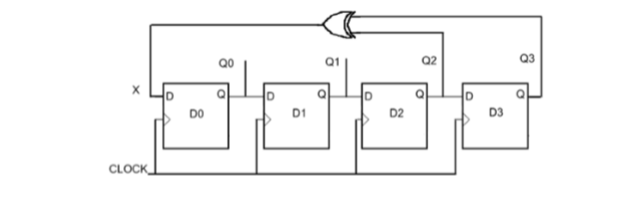

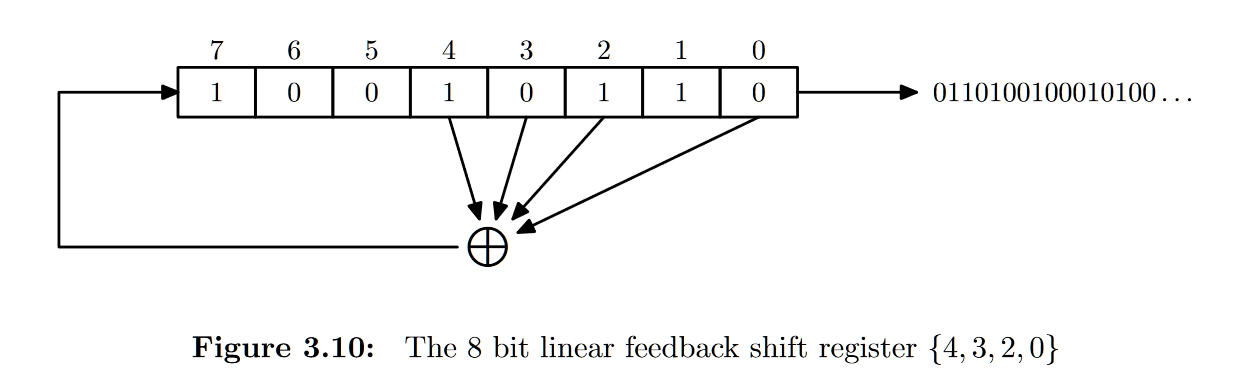

*Intuition*: 
- A shift register
- A feedback loop that feeds into the $m$'th flip flop
- Some xor operations along the feedback loop 
- It's linear because there is a linear recurence relation between the bits

**Construction**
- A bunch of flip flops that are sequentially linked
- A feedback loop that takes the output Q of some of the flip flops and xors them with some xor gates

**Functionality**
- each clock cycle the bits shift 
- the feedback loop takes the Q output from the flip flops and xors them then feeds them to the last register
- the first register outputs the random bit
- The first seed must be different from all zero bits => else the output will be full zeros => The LFSR cannot output full zeros

## Mathematical model

https://www.youtube.com/watch?v=iqGKAu5__lE

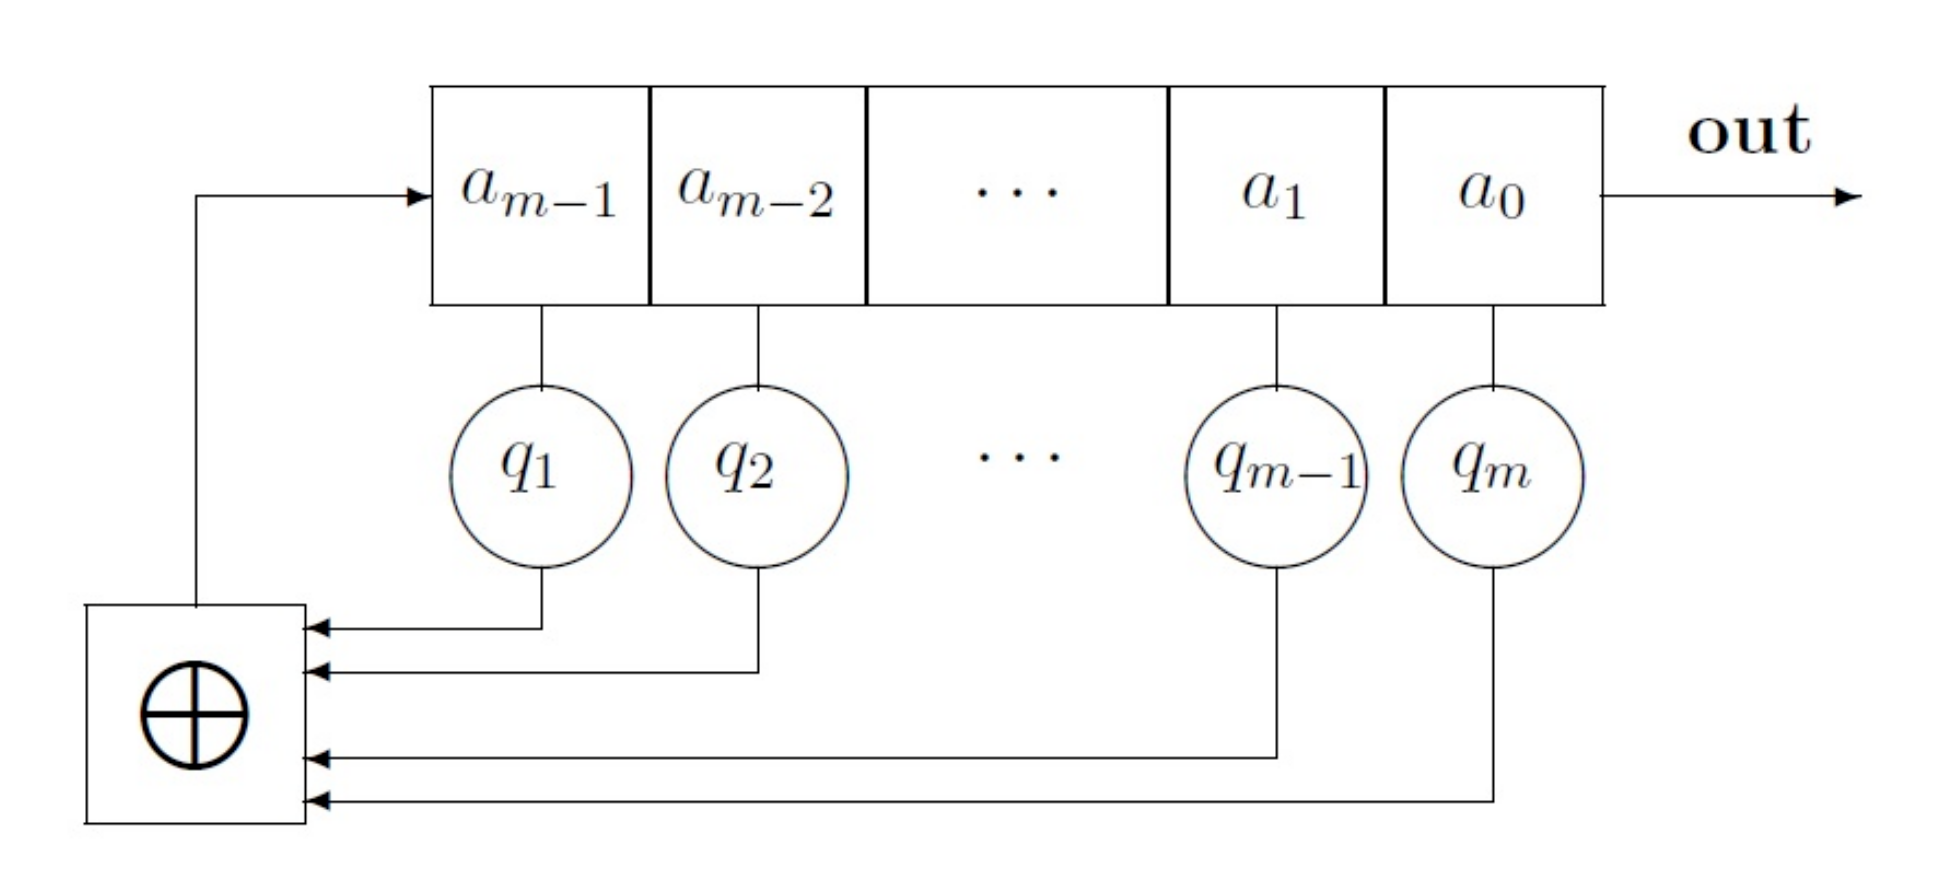

Suppose 
- we have a LFSR with $m$ flip flops $(0, m-1)$ - The number of flip flops is the **order** of the LFSR
- The connection from the $i$'th flip flop output and the XOR gate is represented by a multiplication (AND gate) between the output bit $s_i$ and some bit $p_i \in \{0, 1\}$

Then we can construct the feedback equations:
- $s_m \equiv s_{m-1} \cdot p_{m-1} + s_{m-2} \cdot p_{m-2} + \dots + s_1\cdot p_1 + s_0 \cdot p_0 \bmod 2$
- $s_{m+1} \equiv s_{m} \cdot p_{m-1} + s_{m-1} \cdot p_{m-2} + \dots + s_2\cdot p_1 + s_1 \cdot p_0 \bmod 2$

General case: $$\boxed{s_{m+i} \equiv \sum_{j = 0}^{m - 1} s_{i+j} \cdot p_j \bmod 2}$$

**Polynomial Notation**

$P(X) = X^m + p_{m-1}X^{m-1} + \dots + p_1X + p_0$

### Proprieties

**Theorem**

The maximum period (or sequence length) of a LFSR with $m$ registers is $2^m-1$

**Theorem**

The LFSR's given by a primitive polynomial of degree $m$ has period $2^m - 1$

## An attack

https://www.youtube.com/watch?v=i8WQlBDJTbc

Given
- The degree $m$ of the polynomial
- The ciphertexts $c_i = s_i +  m_i \bmod 2$
- the first $m_0, \dots, m_{2m - 1}$ bits

Step 1: Compute the first $s_i$
- $c_i = s_i +  m_i \bmod 2 =>  s_i = c_i +  m_i \bmod 2$

Step 2: Get the $p_i$
- Construct the system of equations:
    - $s_m \equiv s_{m-1} \cdot p_{m-1} + s_{m-2} \cdot p_{m-2} + \dots + s_1\cdot p_1 + s_0 \cdot p_0 \bmod 2$
    - $s_{m+1} \equiv s_{m} \cdot p_{m-1} + s_{m-1} \cdot p_{m-2} + \dots + s_0\cdot p_1 + s_1 \cdot p_0 \bmod 2$
    - $\vdots$
    - $s_{2m-1} \equiv s_{2m-2} \cdot p_{m-1} + s_{2m-3} \cdot p_{m-2} + \dots + s_{m}\cdot p_1 + s_{m-1} \cdot p_0 \bmod 2$
- Solve it 

Step 3:
- Construct the LFSR using the $p_i$'s found 
- generate the $s_i$ 
- decrypt

## Making LFSR more secure

https://www.youtube.com/watch?v=wr5Dg7vRGgk

Usually multiple LFSR's with different periods are added together to create a non-linear relationship

This improves security although using LFSR's is still not recommended

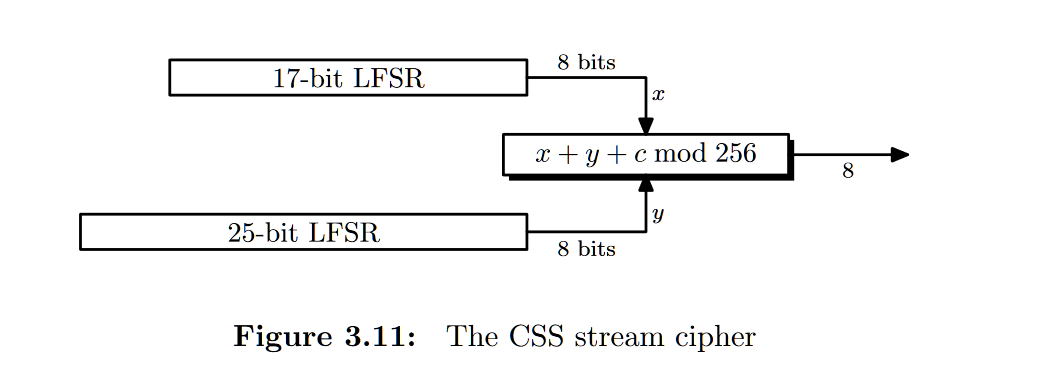

# Code

In [113]:
def int_to_bitlist(n):
    '''LSB is the last bit'''
    l = [(n>>i) & 1 for i in range(n.bit_length())]
    return l
def bitlist_to_int(l):
    '''LSB is the last bit'''
    n = sum([pow(2, i) if b == 1 else 0 for i,b in enumerate(l)])
    return n

In [114]:
l = int_to_bitlist(int(2044))

In [115]:
bitlist_to_int(l)

2044

In [120]:
class LFSR:
    def __init__(self, p_list, s_list):
        '''LSB is on the 0 position'''
        self.p_list = p_list # a list of 0 and 1
        self.s_list_init = s_list.copy()
        self.s_list = s_list.copy()
    
    
    def reset(self):
        '''resets the lfsr to the initial seed'''
        self.s_list = self.s_list_init.copy()
        
        
    def next_bit(self, p_list, s_list):
        '''gets the next bit'''
        s_new = sum([s * p for s,p in zip(s_list, p_list)]) % 2
        return s_new
    
    
    def get_n_bit_sequence(self, n):
        '''gets a sequence of n bits'''
        seq = []
        
        for i in range(n):
            s_next = self.next_bit(self.p_list, self.s_list) #get the next bit
            self.s_list.append(s_next) #insert s_next as msb
            b_out = self.s_list.pop(0) #get out the last bit
            seq.append(b_out)
            
        return seq
            

In [125]:
p_list = [1, 1, 0]
s_list = [0, 0, 1]
lfsr = LFSR(p_list=p_list, s_list=s_list)

In [126]:
lfsr.reset()
l = lfsr.get_n_bit_sequence(14)
print(l)

[0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1]


## Breaking it

In [127]:
m = 256 #the degree

p = getPrime(m)
s = getPrime(m)
p_list = int_to_bitlist(p)
s_list = int_to_bitlist(s)

lfsr = LFSR(p_list=p_list, s_list=s_list)

In [128]:
#get 512 bits
lfsr.reset()
s_list_known = lfsr.get_n_bit_sequence((2 * m)) 

In [132]:
s_list_known[:256] == lfsr.s_list_init #sanity check

True

In [133]:
#construct the system of linear equations
A = [ [s_list_known[i + j] for j in range(m)] for i in range(m)]
b = [s_list_known[i] for i in range(m, 2*m)]

In [137]:
A = matrix(Zmod(2), A)
b = matrix(Zmod(2), b).transpose()

In [144]:
#solve and check
x = A.solve_right(b)

x = list(x.transpose()[0])

x == lfsr.p_list

True

# Resources

- https://en.wikipedia.org/wiki/Linear-feedback_shift_register
- https://www.youtube.com/watch?v=wr5Dg7vRGgk